# 회귀 실습: 자전거 대여(공유) 수요 예측

1. csv 파일 읽어오기
2. info, desc
3. datetime 필드 -> 년, 월, 일, 시간
4. casual(사전에 등록되지 않은 사용자가 대여한 횟수), registered(사용자가 이미 등록되어 있는 사용자의 대여 횟수) 변수가 있음. 

둘을 더하면 총 개수인 y값. 피쳐값 x에 놓으면 오히려 안 좋다. 결정값과 중복되는 값이니 드롭을 시키는 게 좋다.

5. x의 피처별count의 관계를 막대그래프로 시각화
6. 데이터 분리
7. 모델 설정: linearRegression()
8. 훈련, predict
9. matric(rmse, rmsle) 보기
-----
10. feature들을 one-hot encoding으로 변환
*주요 infortance값 시각화 (coef_)

11. RandomForestRegressor, GradientBoostingRegressor 알고리즘 사용
XGBRegressor, LGBMRe
* date : hourly date + timestamp
* season : 1 = 봄, 2 = 여름, 3 = 가을, 4 = 겨울
* holiday : 1 = 토, 일요일의 주말을 제외한 국경일 등의 휴일, 0 = 휴일이 아닌날
* workingday : 1 = 토, 일요일의 주말 및 휴일이 아닌 주중, 0 = 주말 및 휴일
* weather : 1=맑음, 약간 구름 낀 흐림, 2=안개, 안개 + 흐림, 3=가벼운 눈, 가벼운 비 + 천둥, 4=심한 눈/비, 천둥/번개
* temp:온도(섭씨)
* atemp:체감온도(섭씨)
* humidity:상대습도
* windspeed:풍속
* casual:사전에 등록되지 않는 사용자가 대여한 횟수
* registered:사전에 등록된 사용자가 대여한 횟수
* count:대여 횟수

## 1. csv 파일 읽어오기

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score , cross_validate
from sklearn.datasets import load_iris

In [40]:
import pandas as pd

file_path = './bike_train.csv'
df1 = pd.read_csv(file_path)
print(df1)
print('\n')

df2 = pd.read_csv(file_path)
print(df2)

                  datetime  season  holiday  workingday  weather   temp  \
0      2011-01-01 00:00:00       1        0           0        1   9.84   
1      2011-01-01 01:00:00       1        0           0        1   9.02   
2      2011-01-01 02:00:00       1        0           0        1   9.02   
3      2011-01-01 03:00:00       1        0           0        1   9.84   
4      2011-01-01 04:00:00       1        0           0        1   9.84   
...                    ...     ...      ...         ...      ...    ...   
10881  2012-12-19 19:00:00       4        0           1        1  15.58   
10882  2012-12-19 20:00:00       4        0           1        1  14.76   
10883  2012-12-19 21:00:00       4        0           1        1  13.94   
10884  2012-12-19 22:00:00       4        0           1        1  13.94   
10885  2012-12-19 23:00:00       4        0           1        1  13.12   

        atemp  humidity  windspeed  casual  registered  count  
0      14.395        81     0.0000 

## 2. info, desc

In [41]:
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB
None


In [42]:
print(df2.describe())

             season       holiday    workingday       weather         temp  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.00000   
mean       2.506614      0.028569      0.680875      1.418427     20.23086   
std        1.116174      0.166599      0.466159      0.633839      7.79159   
min        1.000000      0.000000      0.000000      1.000000      0.82000   
25%        2.000000      0.000000      0.000000      1.000000     13.94000   
50%        3.000000      0.000000      1.000000      1.000000     20.50000   
75%        4.000000      0.000000      1.000000      2.000000     26.24000   
max        4.000000      1.000000      1.000000      4.000000     41.00000   

              atemp      humidity     windspeed        casual    registered  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      23.655084     61.886460     12.799395     36.021955    155.552177   
std        8.474601     19.245033      8.164537     49.96047

## 3. datetime 필드 -> 년, 월, 일, 시간

In [43]:
df2['datetime']

0        2011-01-01 00:00:00
1        2011-01-01 01:00:00
2        2011-01-01 02:00:00
3        2011-01-01 03:00:00
4        2011-01-01 04:00:00
                ...         
10881    2012-12-19 19:00:00
10882    2012-12-19 20:00:00
10883    2012-12-19 21:00:00
10884    2012-12-19 22:00:00
10885    2012-12-19 23:00:00
Name: datetime, Length: 10886, dtype: object

In [44]:
df2['time1'] = df2['datetime'].apply(lambda x: x.split(' ')[0])
df2['time1']

0        2011-01-01
1        2011-01-01
2        2011-01-01
3        2011-01-01
4        2011-01-01
            ...    
10881    2012-12-19
10882    2012-12-19
10883    2012-12-19
10884    2012-12-19
10885    2012-12-19
Name: time1, Length: 10886, dtype: object

In [15]:
df2['time2'] = df2['datetime'].apply(lambda x: x.split(' ')[1])
df2['time2']

0        00:00:00
1        01:00:00
2        02:00:00
3        03:00:00
4        04:00:00
           ...   
10881    19:00:00
10882    20:00:00
10883    21:00:00
10884    22:00:00
10885    23:00:00
Name: time2, Length: 10886, dtype: object

In [16]:
df2['time1'].apply(lambda x: x.split('-'))

0        [2011, 01, 01]
1        [2011, 01, 01]
2        [2011, 01, 01]
3        [2011, 01, 01]
4        [2011, 01, 01]
              ...      
10881    [2012, 12, 19]
10882    [2012, 12, 19]
10883    [2012, 12, 19]
10884    [2012, 12, 19]
10885    [2012, 12, 19]
Name: time1, Length: 10886, dtype: object

In [47]:
df2['year'] = df2['time1'].apply(lambda x: x.split('-')[0])
df2['month'] = df2['time1'].apply(lambda x: x.split('-')[1])
df2['day'] = df2['time1'].apply(lambda x: x.split('-')[2])
df2['time2'] = df2['datetime'].apply(lambda x: x.split(' ')[1])
#[1]이런 인덱스 괄호 위치에 따라 행으로 추출되기도, 열로 추출되기도 함
df2

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,time1,year,month,day,time2
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011-01-01,2011,01,01,00:00:00
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011-01-01,2011,01,01,01:00:00
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011-01-01,2011,01,01,02:00:00
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011-01-01,2011,01,01,03:00:00
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011-01-01,2011,01,01,04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012-12-19,2012,12,19,19:00:00
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012-12-19,2012,12,19,20:00:00
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012-12-19,2012,12,19,21:00:00
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012-12-19,2012,12,19,22:00:00


In [48]:
# dt.year
# df2['time']=1 #새로운 열을 만들어주는 것
# df2

In [49]:
df2['time1']

0        2011-01-01
1        2011-01-01
2        2011-01-01
3        2011-01-01
4        2011-01-01
            ...    
10881    2012-12-19
10882    2012-12-19
10883    2012-12-19
10884    2012-12-19
10885    2012-12-19
Name: time1, Length: 10886, dtype: object

In [50]:
df2['time1'].apply(lambda x: x.split('-'))

0        [2011, 01, 01]
1        [2011, 01, 01]
2        [2011, 01, 01]
3        [2011, 01, 01]
4        [2011, 01, 01]
              ...      
10881    [2012, 12, 19]
10882    [2012, 12, 19]
10883    [2012, 12, 19]
10884    [2012, 12, 19]
10885    [2012, 12, 19]
Name: time1, Length: 10886, dtype: object

## 4. casual(사전에 등록되지 않은 사용자가 대여한 횟수), registered(사용자가 이미 등록되어 있는 사용자의 대여 횟수) 변수가 있음. 

둘을 더하면 총 개수인 y값. 피쳐값 x에 놓으면 오히려 안 좋다. 결정값과 중복되는 값이니 드롭을 시키는 게 좋다.

In [51]:
# df2.drop(['casual', 'registered'], axis = 1, inplace = True)
df2.drop(['time'], axis = 1, inplace = True)

KeyError: "['time'] not found in axis"

In [53]:
df2

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,time1,year,month,day,time2
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011-01-01,2011,01,01,00:00:00
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011-01-01,2011,01,01,01:00:00
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011-01-01,2011,01,01,02:00:00
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011-01-01,2011,01,01,03:00:00
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011-01-01,2011,01,01,04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012-12-19,2012,12,19,19:00:00
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012-12-19,2012,12,19,20:00:00
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012-12-19,2012,12,19,21:00:00
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012-12-19,2012,12,19,22:00:00


## 5. x의 피처별count의 관계를 막대그래프로 시각화

<AxesSubplot: xlabel='time2', ylabel='count'>

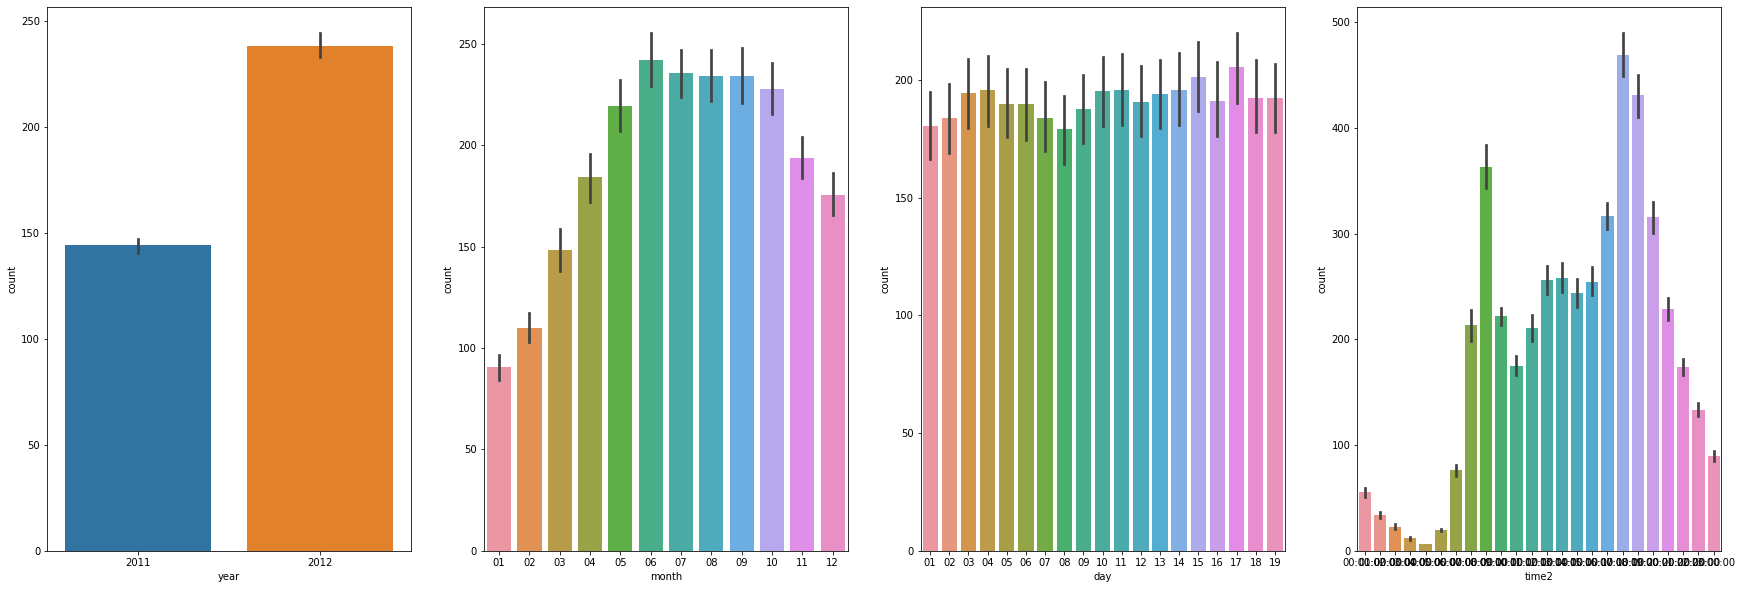

In [70]:
figure, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4)
figure.set_size_inches(30, 10)

sns.barplot(data=df2, x='year', y='count', ax=ax1)
sns.barplot(data=df2, x='month', y='count', ax=ax2)
sns.barplot(data=df2, x='day', y='count', ax=ax3)
sns.barplot(data=df2, x='time2', y='count', ax=ax4)

## 6. 데이터 분리

train
test
split